In [14]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import matplotlib
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline 

#matplotlib.use('Agg')

In [15]:
def calibration_paras():
    img_lists = glob.glob('./camera_cal/*.jpg')
    calibration_images = []
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    for fname in img_lists:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist

In [16]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None



def corners_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    
    #gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # Search for corners in the grayscaled image
       # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 300 # offset for dst points
    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])                      
    src = np.float32([[700,450],[1100,img_size[1]],[180,img_size[1]],[600,450]])
    offset = 300 # offset for dst points
    dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset, img_size[1]],[offset, 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M


def to_binaryimg(img, s_thresh, sb_thresh, r_thresh, ksize, mtx, dist):
    copied_img = np.copy(img)
    undist_img = cv2.undistort(copied_img, mtx, dist, None, mtx)
    # write the image to a file
    #cv2.imwrite('undistorted_car.png', undist_img)
    
    r_channel = undist_img[:,:,0]
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # binary image for sobel operator
    sbbinary = np.zeros_like(scaled_sobelx)
    sbbinary[(scaled_sobelx >= sb_thresh[0]) & (scaled_sobelx <= sb_thresh[1])] = 1

    rbinary = np.zeros_like(r_channel)
    rbinary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

    # thresholding s channel
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    merged_binary = np.zeros_like(s_channel)
    merged_binary[(sbinary == 1) & (sbbinary == 1) | (rbinary == 1) & (sbbinary == 1) | (sbinary == 1) & (rbinary == 1)] = 1
    #merged_binary[(sbinary == 1) | (sbbinary == 1) | (rbinary == 1)] = 1


    return merged_binary

def nonzerotolrlane(nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

def lane_plotx(fit, y):
    # from a,b,c to line
    x = fit[0]*y**2 + fit[1]*y + fit[2]
    return x

def img_nonzero(img):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzero, nonzerox, nonzeroy

def get_radius(fit, y):
    y_eval = np.max(y)
    rad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    return rad

def get_radius_m(fit, y, my):
    y_eval = np.max(y)
    rad = ((1 + (2*fit[0]*y_eval* my + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    return rad

def update_line(line, leftx, lefty):
# input can be left or right line
    line.current_fit = np.polyfit(lefty, leftx, 2)
    line.allx = leftx
    line.ally = lefty
    
    line.recent_fit.append(line.current_fit)
    n = 5 # number of averaged frames
    line.recent_fit = line.recent_fit[-n:]
    line.best_fit = np.mean(line.recent_fit, axis = 0)
    #left_fit = left_line.current_fit
    line.detected = True


In [19]:
def fit_lines(img, mtx, dist, left_line, right_line):
    #warped_img, M = corners_unwarp(img, mtx, dist)
    warped_img = img
    
    hist = np.sum(warped_img[int(warped_img.shape[0]/2):,:], axis=0)  # lower half of the image
    #plt.plot(hist)
    #plt.show()
    out_img = 255 * np.dstack((warped_img, warped_img, warped_img))

    midxpos = np.int(hist.shape[0] / 2)
    #print (midxpos)
    leftx_base = np.argmax(hist[:midxpos])
    rightx_base = np.argmax(hist[midxpos:]) + midxpos
    n = 9 # number of windows for each lane line
    w_height = np.int(warped_img.shape[0] / n)
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_cur, rightx_cur = leftx_base, rightx_base
    margin = 100
    minpix = 50 #
    left_lane_inds, right_lane_inds = [], []
    for window in range(n):
        win_y_low = warped_img.shape[0] - (window+1)*w_height
        win_y_high = warped_img.shape[0] - window*w_height
        win_xleft_low = leftx_cur - margin
        win_xleft_high = leftx_cur + margin
        win_xright_low = rightx_cur - margin
        win_xright_high = rightx_cur + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_cur = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_cur = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx, lefty, rightx, righty = nonzerotolrlane(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
#    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx = lane_plotx(left_fit, ploty)  # they are floating numbers
    right_fitx = lane_plotx(right_fit, ploty)
    

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0] # red
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] # blue
    
    print (out_img)
#     cv2.imshow('birdview image', out_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()


    plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    plt.savefig('myfig')
    #plt.show()

# left line
    try:
        update_line(left_line, leftx, lefty)
    except TypeError:
        left_line.detected = False
    except np.linalg.LinAlgError:
        left_line.detected = False

    try:
        update_line(right_line, rightx, righty)
    except TypeError:
        right_line.detected = False
    except np.linalg.LinAlgError:
        right_line.detected = False

    # left and right lanes

#return left_fit, right_fit
def get_rad_dist(left_line, right_line, ploty, mx, my, binimg):
    left_rad = get_radius(left_line.current_fit, ploty)
    right_rad = get_radius(right_line.current_fit, ploty)
    left_fit_m = np.polyfit(left_line.ally * my, left_line.allx * mx, 2)
    right_fit_m = np.polyfit(right_line.ally * my, right_line.allx * mx, 2)
    # calculate radius of the curvature
    left_rad_m = get_radius_m(left_line.current_fit, ploty, my)
    right_rad_m = get_radius_m(right_line.current_fit, ploty, my)
    mean_rad = round(np.mean([left_rad_m, right_rad_m]), 0)
    mid_posx = binimg.shape[1] / 2
    car_pos_x = mid_posx * mx
    left_base = lane_plotx(left_fit_m, binimg.shape[0] * my)
    right_base = lane_plotx(right_fit_m, binimg.shape[0] * my)
    mid_lane = (left_base + right_base) / 2
    lanec_to_car = mid_lane - car_pos_x
    return mean_rad, lanec_to_car


def poly_visual_check(img, ploty, left_fit, right_fit, margin):
    out_img = np.dstack((img, img, img)) * 255
    window_img = np.zeros_like(out_img)
    leftx_prev = lane_plotx(left_fit, ploty)
    rightx_prev = lane_plotx(right_fit, ploty)
    left_fitx = leftx_prev
    right_fitx = rightx_prev
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, \
                                                                    ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, \
                                                                     ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    imgplt = plt.imshow(result)
    
    imgplt.plot(left_fitx, ploty, color='yellow')
    imgplt.plot(right_fitx, ploty, color='yellow')
    imgplt.xlim(0, 1280)
    imgplt.ylim(720, 0)
    
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.show()


def merge_poly(orgimg, binimg, M, left_fit_newx, right_fit_newx, ploty):
    # merge the org image with the polygon regions
    MINV = np.linalg.inv(M)
    warp0 = np.zeros_like(binimg).astype(np.uint8)
    color_warp = np.dstack((warp0, warp0, warp0))
    ppoints_left = np.array([np.transpose(np.vstack([left_fit_newx, ploty]))])
    ppoints_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_newx, ploty])))])
    # print (ppoints_left, ppoints_right)
    ppoints = np.hstack((ppoints_left, ppoints_right))
    cv2.fillPoly(color_warp, np.int_([ppoints]), (0,255,0)) # green
    newwarp = cv2.warpPerspective(color_warp, MINV, (orgimg.shape[1], orgimg.shape[0]))
    result = cv2.addWeighted(orgimg, 1, newwarp, 0.3, 0)
    return result

def count_check(line):
    """ Resets to using new sliding windows below if
        upon failing five times in a row.
        """
    if line.counter >= 5:
        line.detected = False


def draw_lines(left_line, right_line, orgimg, binimg, mtx, dist, M):
    # img is a warped image
    if left_line.detected == False | right_line.detected == False:
        fit_lines(binimg, mtx, dist, left_line, right_line)
    left_fit = left_line.current_fit # polynomial coefficients
    right_fit = right_line.current_fit
    nonzero, nonzerox, nonzeroy = img_nonzero(binimg)
    margin = 100

    ploty = np.linspace(0, binimg.shape[0]-1, binimg.shape[0])

    leftx_prev = lane_plotx(left_fit, nonzeroy)
    rightx_prev = lane_plotx(right_fit, nonzeroy)

    ## visual check
    # poly_visual_check(img, ploty, left_fit, right_fit, margin)


    left_lane_inds = ((nonzerox > leftx_prev - margin) & (nonzerox < leftx_prev + margin))
    right_lane_inds = ((nonzerox > rightx_prev - margin) & (nonzerox < rightx_prev + margin))
    leftx, lefty, rightx, righty = nonzerotolrlane(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)


    try:
        update_line(left_line, leftx, lefty)
    except TypeError:
        left_fit = left_line.best_fit
#        count_check(left_line)
    except np.linalg.LinAlgError:
        left_fit = left_line.best_fit
#        count_check(left_line)

    try:
        update_line(right_line, rightx, righty)
    except TypeError:
        right_fit = right_line.best_fit
#        count_check(right_line)
    except np.linalg.LinAlgError:
        right_fit = right_line.best_fit
#        count_check(right_line)

    # update two lines
#    update_line(left_line, leftx, lefty)
#    update_line(right_line, rightx, righty)

    # fit the new lines with uniform x
    left_fit_newx = lane_plotx(left_line.current_fit, ploty)
    right_fit_newx = lane_plotx(right_line.current_fit, ploty)

    # curvature
    mx = 3.7 / 700
    my = 30 / 720
    mean_rad, lanec_to_car = get_rad_dist(left_line, right_line, ploty, mx, my, binimg)
    
    # print text and poly together
    rad_text = "Radius of Curvature = {}(m)".format(mean_rad)
    #print (mean_rad)
    if lanec_to_car >= 0:
        dist_text = "{} meters left of center".format(round(lanec_to_car,2))
    else:
        dist_text = "{} meters right of center".format(round(-lanec_to_car,2))

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(orgimg, dist_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(orgimg, rad_text, (10,100), font, 1,(255,255,255),2)


    result = merge_poly(orgimg, binimg, M, left_fit_newx, right_fit_newx, ploty)

#    plt.imshow(result)
#    plt.show()

    return result

# display and choose the coordinates
#img = cv2.imread('./test_images/test1.jpg',0)
#plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#plt.show()

# global variables for convience
left_line = Line()
right_line = Line()
ret, mtx, dist = calibration_paras()

# def process_pipeline(img, left_line, right_line):
def process_pipeline(img):
    #ret, mtx, dist = calibration_paras()

    # birdview_img, _ = corners_unwarp(img, mtx, dist)
    s_thresh=(125, 255)
    sb_thresh=(10, 100)
    r_thresh = (200, 255)
    temp_img = to_binaryimg(img, s_thresh, sb_thresh, r_thresh, 3, mtx, dist)
    
#     cv2.imshow('birdview image', temp_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    
    birdview_img, M = corners_unwarp(temp_img, mtx, dist)
    
    
    #result = draw_lines(left_line, right_line, img, birdview_img, mtx, dist, M)
    fit_lines(birdview_img, mtx, dist, left_line, right_line)
    

    #return result


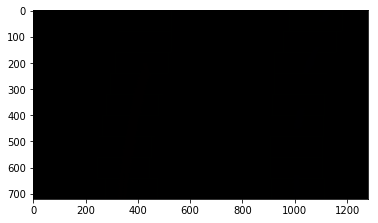

In [20]:
if __name__ == '__main__':
#    left_line = Line()
#    right_line = Line()
    # single image test
    img = cv2.imread('./test_images/test3.jpg')
    process_pipeline(img)